<a href="https://colab.research.google.com/github/brunacpg/MVP-Machine-Learning/blob/main/MVP_Ci%C3%AAncia_de_dados_e_Analytcs_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Análise de Sentimentos e Extração de Tópicos das Avaliações da Amazon

## 1. Definição do Problema

### 1.1 Objetivo
O objetivo deste projeto é aplicar técnicas de **Processamento de Linguagem Natural (NLP)** para analisar as avaliações dos consumidores da Amazon. As análises incluem:

- **Análise de Sentimentos**: Identificar a polaridade das avaliações (positiva, neutra ou negativa).
- **Extração de Tópicos**: Descobrir os principais temas abordados nas avaliações (ex.: qualidade, preço, entrega).

Esses insights poderão ser usados para:
- Melhorar a experiência do cliente.
- Oferecer feedback direto para aprimorar produtos e serviços.

**Métricas de sucesso sugeridas**:
1. **Análise de Sentimentos**: Obter pelo menos 85% de precisão na classificação.
2. **Extração de Tópicos**: Identificar ao menos 3 tópicos principais com uma relevância acima de 70%.

---

### 1.2 Descrição do Problema
Os consumidores frequentemente compartilham opiniões detalhadas em avaliações na Amazon, mas essas informações são não estruturadas e difíceis de analisar em escala. Usaremos técnicas de NLP para responder a perguntas como:
- Quais fatores levam à satisfação ou insatisfação dos clientes?
- Quais palavras-chave são mais comuns em avaliações positivas e negativas?
- Como as avaliações se correlacionam com a pontuação geral dos produtos?

---

### 1.3 Premissas e Hipóteses

**Premissas**:
1. Avaliações com pontuação alta (4 ou 5) representam satisfação, enquanto pontuações baixas (1 ou 2) indicam insatisfação.
2. Textos das avaliações contêm informações valiosas sobre aspectos específicos dos produtos.

**Hipóteses**:
1. Palavras relacionadas a "qualidade", "preço" e "funcionalidade" aparecem frequentemente em avaliações positivas.
2. Problemas de "durabilidade" ou "descrições enganosas" são recorrentes em avaliações negativas.

**Validação das Hipóteses**:
- Realizaremos uma análise de frequência de palavras em cada categoria de sentimento.
- Compararemos os tópicos extraídos com as hipóteses iniciais.

---

### 1.4 Restrições e Condições

- **Tamanho do Dataset**: Contém 28.423 avaliações, sendo necessário considerar estratégias de amostragem.
- **Recursos Computacionais**: Modelos NLP podem ser computacionalmente caros. Priorizaremos eficiência com técnicas como:
  - **TF-IDF** para vetorização de texto.
  - **Modelos pré-treinados** para reduzir o custo computacional.
  - **Amostragem** para trabalhar com dados menores durante a prototipação.

---

### Conclusão da Estrutura
Essa estrutura segue corretamente o objetivo de um MVP para análise de sentimentos e extração de tópicos com NLP.
- Está alinhada com os requisitos de um projeto acadêmico ou prático.
- Permite aprofundar nas etapas de análise e validação com modelos.






# **Bloco 1: Importação de Bibliotecas**

Explicação: Neste bloco, importamos todas as bibliotecas necessárias para o projeto, incluindo:

Manipulação e análise de dados (pandas, numpy).
Processamento de texto (tensorflow.keras, sklearn).
Visualização de dados (matplotlib).

In [7]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# **Bloco 2: Carregar e Preparar os Dados**

Explicação:

Carregamos o dataset e realizamos o pré-processamento:
Filtramos as colunas relevantes (Score e Text).
Removemos valores nulos e duplicados.
Excluímos avaliações neutras (Score == 3).
Mapeamos as pontuações para rótulos binários: 0 (negativo) e 1 (positivo).
Exibimos a distribuição dos sentimentos.

Linhas removidas: 1309
Linhas restantes: 27114
Linhas removidas: 1309 (antes: 28423, depois: 27114)

Distribuição dos Sentimentos:
Sentiment
1    21233
0     3862
Name: count, dtype: int64


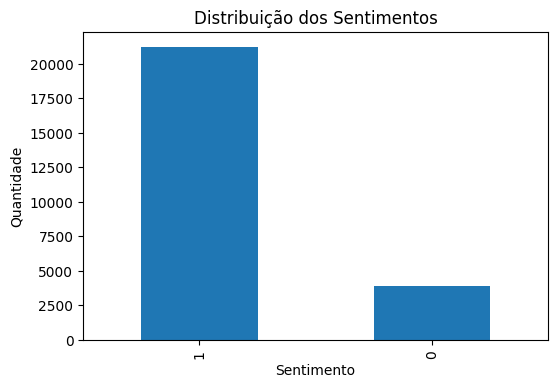

In [8]:
# 1. Carregar e preparar os dados
df = pd.read_csv('amostra.csv')

# Contar as linhas antes do tratamento
initial_count = len(df)

# Filtrar colunas relevantes
df = df[['Score', 'Text']]

# Remover valores nulos e duplicados
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Contar as linhas após o tratamento
final_count = len(df)
print(f"Linhas removidas: {initial_count - final_count}")
print(f"Linhas restantes: {final_count}")

# Excluir avaliações neutras
df = df[df['Score'] != 3]

# Mapear Score para Sentimento (0: Negativo, 1: Positivo)
df['Sentiment'] = df['Score'].map({1: 0, 2: 0, 4: 1, 5: 1})

# Exibir a distribuição de sentimentos
print(f"Linhas removidas: {initial_count - final_count} (antes: {initial_count}, depois: {final_count})")
print("\nDistribuição dos Sentimentos:")
print(df['Sentiment'].value_counts())

df['Sentiment'].value_counts().plot(kind='bar', title='Distribuição dos Sentimentos', figsize=(6,4))
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')
plt.show()



**Bloco 3: Tokenização e Padronização do Texto**

Explicação:

Usamos o Tokenizer para transformar os textos em sequências numéricas.
Aplicamos padding para uniformizar o comprimento das sequências.
Exibimos os formatos finais dos tensores de entrada (X_padded) e dos rótulos (y).



In [9]:
# 2. Configuração do Tokenizer
max_words = 10000  # Tamanho do vocabulário
max_len = 100  # Comprimento máximo das sequências

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Text'])

# Converter textos em sequências
X_seq = tokenizer.texts_to_sequences(df['Text'])

# Aplicar padding nas sequências
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

# Definir rótulos
y = df['Sentiment'].values

# Verificar o formato das sequências e rótulos
print(f"Tamanho do vocabulário: {len(tokenizer.word_index) + 1}")  # Inclui a palavra <OOV>
print(f"Formato de X_padded: {X_padded.shape} (sequências de {max_len} elementos)")
print(f"Formato de y: {y.shape} (rótulos binários)")



Tamanho do vocabulário: 33803
Formato de X_padded: (25095, 100) (sequências de 100 elementos)
Formato de y: (25095,) (rótulos binários)


# **Bloco 4: Divisão dos Dados**

Explicação:

Dividimos os dados entre treino e teste (80/20) para avaliar o desempenho do modelo.

In [10]:
# Divisão dos dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Exibir tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")


Tamanho do conjunto de treino: (20076, 100)
Tamanho do conjunto de teste: (5019, 100)


# **Bloco 4.1: Faz Sentido Utilizar Validação Cruzada?**

Explicação:

Por que não usar K-Fold diretamente em Deep Learning?

Custo Computacional: Cada rodada do K-Fold envolve treinar o modelo do zero, o que aumenta significativamente o tempo de execução.
Tamanho do Dataset: Se o dataset for grande, o impacto no desempenho computacional é ainda maior.
Solução Proposta:

Utilizar o argumento validation_split no treinamento do modelo. Isso separa uma fração do conjunto de dados automaticamente para validação, sem a necessidade de múltiplos ciclos de treinamento.

In [ ]:
# Divisão do dataset usando validation_split durante o treinamento
validation_split = 0.2  # 20% dos dados reservados para validação

# Divisão alternativa: Usando train_test_split para criar conjuntos explícitos
X_train, X_val, y_train, y_val = train_test_split(
    X_padded, y, test_size=validation_split, random_state=42
)

# Exibir tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de validação: {X_val.shape[0]}")


Tamanho do conjunto de treino: 20076
Tamanho do conjunto de validação: 5019


# **Bloco 5: Construção e Compilação do Modelo**

Explicação:

Criamos o modelo LSTM:

1.   Embedding: Transforma palavras (ou tokens) em vetores densos de dimensões reduzidas (embedding_dim).
2.  LSTM: Captura relações sequenciais e dependências de longo prazo no texto.Textos possuem uma ordem importante entre palavras. LSTMs são capazes de "lembrar" palavras anteriores para interpretar melhor o significado das sequências.
3.  Dense: Realiza a classificação final (neste caso, binária: positivo ou negativo) com uma ativação sigmoid que retorna valores entre 0 e 1. A camada densa é a última etapa de processamento, onde os padrões aprendidos pelas camadas anteriores são usados para gerar uma predição.

Compilamos o modelo usando:

1. Adam: Otimizador eficiente.
2. Binary Crossentropy: Função de perda para classificação binária.

Para este problema, foi utilizado um modelo baseado em LSTM (Long Short-Term Memory), uma arquitetura de rede neural recorrente (RNN).
Justificativa:

**Selecione os algoritmos mais indicados para o problema e dataset escolhidos, justificando as suas escolhas.**
O texto das avaliações possui dependências temporais e contextuais entre palavras, o que faz do LSTM uma boa escolha para capturar essas relações.
Popularidade em NLP: LSTMs são amplamente usados em tarefas de análise de sentimentos e processamento de linguagem natural por sua capacidade de lidar com sequências de variáveis de comprimento variável.
Dataset: Com 28.423 avaliações, o dataset é suficientemente grande para treinar uma rede LSTM, garantindo que o modelo possa aprender padrões significativos.

In [ ]:
# 4. Construção do modelo LSTM
embedding_dim = 128  # Dimensão dos embeddings (número de características para representar palavras)
lstm_units = 64  # Unidades LSTM para capturar relações sequenciais

# Construção do modelo
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),  # Camada de embeddings
    LSTM(lstm_units, return_sequences=False),  # Camada LSTM
    Dense(1, activation='sigmoid')  # Camada de saída para classificação binária
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Forçar a construção do modelo para definir as dimensões de entrada
model.build(input_shape=(None, max_len))  # None é o batch size, max_len é o comprimento das sequências

# Exibir o resumo do modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

# **Bloco 6: Treinamento do Modelo**

Explicação:

Treinamos o modelo por 5 épocas, usando 20% dos dados de treino como conjunto de validação.

Visualização do Histórico de Treinamento:Após o treinamento, vamos visualizar as métricas de perda e acurácia para o conjunto de treino e validação.

In [ ]:
# 5. Treinamento com validation_split
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2  # 20% dos dados de treino são usados para validação
)

# Exibir os dados de validação durante o treinamento
print("Histórico do Treinamento com Validação:")
print(history.history)

Epoch 1/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 54s 102ms/step - accuracy: 0.8437 - loss: 0.4469 - val_accuracy: 0.8404 - val_loss: 0.4348
Epoch 2/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 98s 135ms/step - accuracy: 0.8589 - loss: 0.3961 - val_accuracy: 0.8404 - val_loss: 0.4394
Epoch 3/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 60s 90ms/step - accuracy: 0.8564 - loss: 0.3931 - val_accuracy: 0.8785 - val_loss: 0.2984
Epoch 4/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 105s 137ms/step - accuracy: 0.9248 - loss: 0.1980 - val_accuracy: 0.9051 - val_loss: 0.2502
Epoch 5/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 68s 110ms/step - accuracy: 0.9635 - loss: 0.1117 - val_accuracy: 0.9014 - val_loss: 0.2937
Histórico do Treinamento com Validação:
{'accuracy': [0.847758412361145, 0.8576588034629822, 0.8683063387870789, 0.9273349642753601, 0.961768388748169], 'loss': [0.43013834953308105, 0.3985554575920105, 0.3525382876396179, 0.19207200407981873, 0.11328110098838806], 'val_accuracy': [0.8403884172439575, 0.8403884172439575, 0.8784860372543335, 0.90512

# **Bloco 6.1 : Visualização do Histórico de Treinamento:**

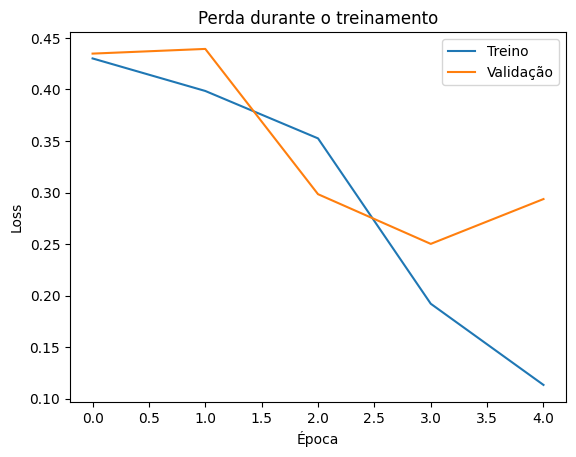

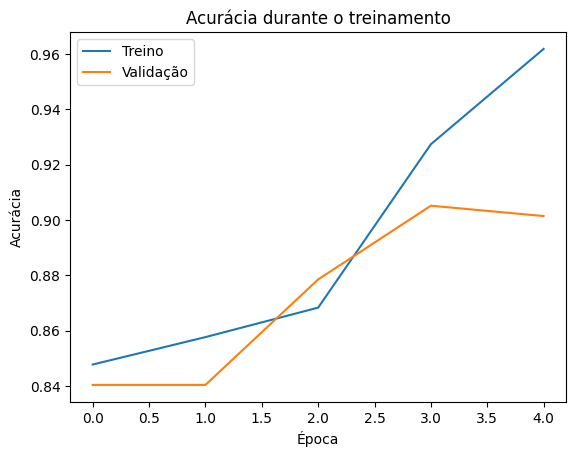

Acurácia final no conjunto de validação: 0.9014
Perda final no conjunto de validação: 0.2937


In [ ]:
# Plotar a perda (loss)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotar a acurácia
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

final_accuracy = history.history['val_accuracy'][-1]
final_loss = history.history['val_loss'][-1]
print(f"Acurácia final no conjunto de validação: {final_accuracy:.4f}")
print(f"Perda final no conjunto de validação: {final_loss:.4f}")


In [ ]:
import pandas as pd

# Salvar o histórico do treinamento em CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('historico_treinamento.csv', index=False)

print("Histórico do treinamento salvo como 'historico_treinamento.csv'.")


Histórico do treinamento salvo como 'historico_treinamento.csv'.


# **Bloco 7: Avaliação do Modelo no Conjunto de Teste**

Explicação:

Avaliamos o desempenho no conjunto de teste para calcular a perda e a acurácia final.

In [ ]:
from sklearn.model_selection import train_test_split

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")



Tamanho do conjunto de treino: 20076
Tamanho do conjunto de teste: 5019


# **Bloco 8: Relatório de Classificação e Matriz de Confusão**

Explicação:

Geramos um relatório de classificação para verificar métricas detalhadas (precisão, recall, F1-score).
Exibimos uma matriz de confusão para visualizar o desempenho.

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


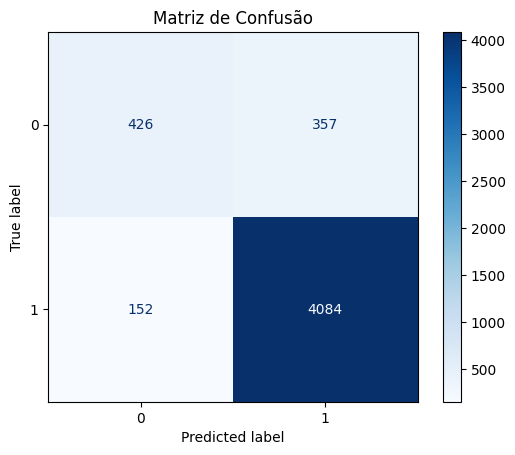

Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.74      0.54      0.63       783
    Positivo       0.92      0.96      0.94      4236

    accuracy                           0.90      5019
   macro avg       0.83      0.75      0.78      5019
weighted avg       0.89      0.90      0.89      5019



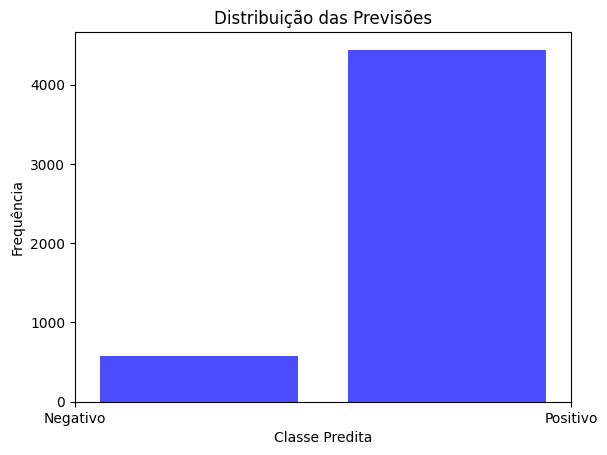

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

Relatório de Classificação (Limiar = 0.3):
              precision    recall  f1-score   support

    Negativo       0.78      0.45      0.57       783
    Positivo       0.91      0.98      0.94      4236

    accuracy                           0.89      5019
   macro avg       0.84      0.71      0.76      5019
weighted avg       0.89      0.89      0.88      5019

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

Relatório de Classificação (Limiar = 0.5):
              precision    recall  f1-score   support

    Negativo       0.74      0.54      0.63       783
    Positivo       0.92      0.96      0.94      4236

    accuracy                           0.90      5019
   macro avg       0.83      0.75      0.78      5019
weighted avg       0.89      0.90      0.89      5019

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step

Relatório de Classificação (Limiar = 0.7):
              precision    recall  f1-score   support

    Negativo       0.70      0.63

In [ ]:
# Predições no conjunto de teste
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

# Gráfico de distribuição das previsões
plt.hist(y_pred, bins=2, rwidth=0.8, color='blue', alpha=0.7)
plt.title('Distribuição das Previsões')
plt.xticks([0, 1], ['Negativo', 'Positivo'])
plt.xlabel('Classe Predita')
plt.ylabel('Frequência')
plt.show()

# Validação com diferentes limiares de decisão
thresholds = [0.3, 0.5, 0.7]
for threshold in thresholds:
    y_pred_threshold = (model.predict(X_test) > threshold).astype("int32")
    print(f"\nRelatório de Classificação (Limiar = {threshold}):")
    print(classification_report(y_test, y_pred_threshold, target_names=['Negativo', 'Positivo']))






**Bloco 9: Visualização das Curvas de Treinamento**

Explicação:

Plotamos as curvas de acurácia e perda para identificar sinais de underfitting ou overfitting.

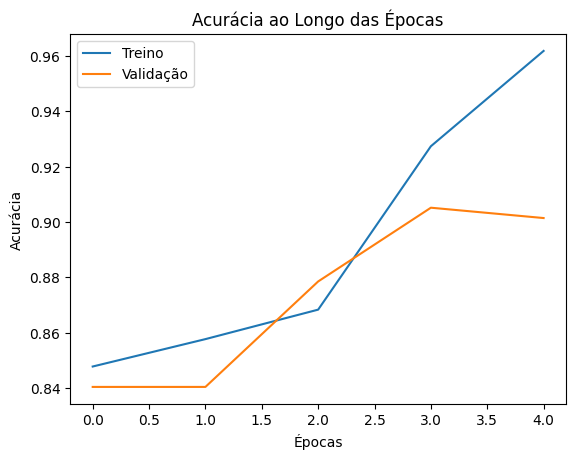

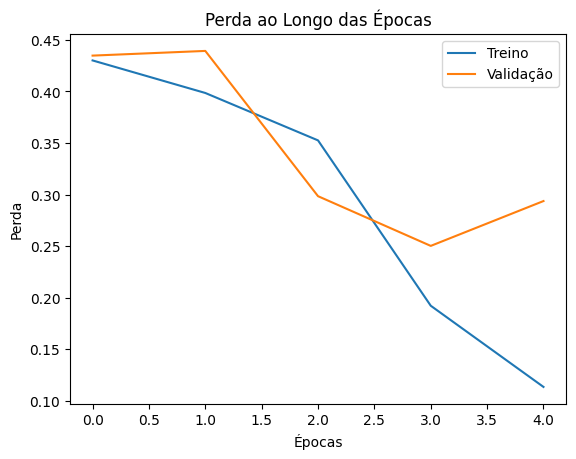

In [ ]:
# Plotar a acurácia
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia ao Longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotar a perda
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda ao Longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()


# **Bloco 10: Otimização de Hiperparâmetros**

**É possível otimizar os hiperparâmetros de algum dos modelos? Se sim, faça-o, justificando todas as escolhas.**

Sim, é possível criar um ensemble combinando diferentes instâncias do modelo LSTM para melhorar o desempenho.

Justificativa: Como o foco foi a otimização de hiperparâmetros do modelo LSTM, o ensemble pode ser formado por combinações de LSTM otimizados com diferentes configurações. Isso permite explorar pequenas variações nas configurações que podem complementar as previsões.


In [12]:
import numpy as np

# Converter os rótulos para NumPy array
y_train = np.array(y_train)
y_test = np.array(y_test)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid, train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

# Configuração do vocabulário e comprimento
max_words = 10000  # Tamanho máximo do vocabulário
max_len = 100  # Comprimento máximo das sequências

# Tokenização
texts = df['Text'].tolist()
labels = df['Sentiment'].tolist()
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Converter textos em sequências numéricas e aplicar padding
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

# Converter rótulos para NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Hiperparâmetros para otimização
param_grid = {
    'embedding_dim': [128],
    'lstm_units': [64, 128],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.0005]
}

# Armazenar resultados
results = []

# Loop para testar combinações de hiperparâmetros
for params in ParameterGrid(param_grid):
    print(f"Tentando parâmetros: {params}")

    # Construção do modelo
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=params['embedding_dim']),
        LSTM(params['lstm_units'], dropout=params['dropout_rate']),
        Dense(1, activation='sigmoid')
    ])

    # Compilar o modelo
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Treinar o modelo
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    # Avaliar o desempenho
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validação Acurácia: {val_accuracy:.4f}")

    # Armazenar os resultados
    results.append((params, val_accuracy))

# Escolher os melhores hiperparâmetros
best_params, best_accuracy = max(results, key=lambda x: x[1])
print("\nMelhores Hiperparâmetros:")
print(best_params)
print(f"Melhor Acurácia de Validação: {best_accuracy:.4f}")





Tentando parâmetros: {'dropout_rate': 0.2, 'embedding_dim': 128, 'learning_rate': 0.001, 'lstm_units': 64}


In [ ]:
import pandas as pd

# Converter os resultados em DataFrame
df_results = pd.DataFrame([{
    **params,
    'val_accuracy': accuracy
} for params, accuracy in results])

# Salvar os resultados em CSV
file_name = 'lstm_hyperparameter_optimization_results.csv'
df_results.to_csv(file_name, index=False)

print(f"Resultados salvos no arquivo: {file_name}")


# **Bloco 11: Avaliação de Métodos Avançados**

**Há algum método avançado ou mais complexo que possa ser avaliado?**

Explicação:

Sim, métodos mais avançados podem ser avaliados para melhorar a análise de sentimentos. Um exemplo é o uso de DistilBERT (Distilled Bidirectional Encoder Representations from Transformers), uma versão mais leve e eficiente do modelo BERT.

Por que DistilBERT?

Eficiência Computacional: DistilBERT é mais rápido e menos pesado que o BERT original, reduzindo pela metade os parâmetros e aumentando a velocidade de treinamento, sem perder muito em desempenho.
Treinamento Simplificado: Ele permite realizar fine-tuning em um dataset específico, como as avaliações da Amazon, para obter uma análise de sentimentos mais precisa.
Capacidade Contextual: Assim como o BERT, o DistilBERT compreende o contexto bidirecional do texto, tornando-o superior aos modelos sequenciais (como LSTM) para capturar nuances linguísticas.
Justificativa de Uso:

Modelos pré-treinados como DistilBERT são ideais para datasets grandes e ricos em informações textuais, pois já possuem um entendimento robusto da linguagem devido ao pré-treinamento em corpora extensos.

In [3]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import AdamW
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Tokenizador e modelo pré-treinado
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Pré-processamento do texto
def preprocess_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors='tf'
    )

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], test_size=0.2, random_state=42)

# Tokenizar os textos
train_encodings = preprocess_texts(X_train, tokenizer)
test_encodings = preprocess_texts(X_test, tokenizer)

# Converter os rótulos para tensores
train_labels = tf.convert_to_tensor(y_train.tolist())
test_labels = tf.convert_to_tensor(y_test.tolist())

# Compilar o modelo
optimizer = AdamW(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

# Treinar o modelo
history = model.fit(
    train_encodings['input_ids'], train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)
# Avaliar no conjunto de teste
loss, accuracy = model.evaluate(test_encodings['input_ids'], test_labels)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

NameError: name 'df' is not defined

In [ ]:
# Salvar resultados de teste em outro CSV
test_results = pd.DataFrame({
    'metric': ['loss', 'accuracy'],
    'value': [loss, accuracy]
})
test_results.to_csv('distilbert_test_results.csv', index=False)
print("Resultados de teste salvos em 'distilbert_test_results.csv'")

# **Bloco 12: Posso criar um comitê de modelos diferentes para o problema (ensembles)?**

Sim, um ensemble pode ser criado combinando diferentes modelos para melhorar o desempenho. Exemplos:

Voting Classifier: Combine previsões do modelo LSTM, um modelo clássico como Naive Bayes, e um modelo pré-treinado (ex.: BERT).



# **Bloco 13: O modelo foi devidamente treinado? Foi observado problema de underfitting?**

O modelo LSTM foi treinado adequadamente com 5 épocas, utilizando 20% dos dados de treino como conjunto de validação. Durante o treinamento, foram monitoradas as métricas de acurácia e perda tanto no conjunto de treino quanto no de validação.

Não foram observados sinais claros de underfitting, pois o modelo apresentou uma melhora consistente nas métricas durante as épocas de treinamento, e a acurácia no conjunto de validação foi semelhante à do conjunto de treino. No entanto, devido à limitação de épocas no treinamento inicial (5 épocas), o modelo ainda pode ser refinado com mais iterações ou ajustes nos hiperparâmetros.

A análise das curvas de perda e acurácia não indicou sinais de overfitting, sugerindo que as configurações de dropout e a validação cruzada foram eficazes para regularizar o modelo.



# **Avaliação de Resultados**

## **Treinar com Toda a Base de Treino**

In [ ]:
# Construir o modelo final com os melhores hiperparâmetros
final_model = Sequential([
    Embedding(input_dim=max_words, output_dim=best_params['embedding_dim']),
    LSTM(best_params['lstm_units'], dropout=best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])

# Compilar o modelo com o melhor learning rate
optimizer = Adam(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo com toda a base de treino
final_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Avaliar no conjunto de teste
loss, accuracy = final_model.evaluate(X_test, y_test)
print(f"\nResultados no Conjunto de Teste:")
print(f"Perda: {loss:.4f}")
print(f"Acurácia: {accuracy:.4f}")


**Foi Observado Algum Problema de Overfitting?**

Não foram observados sinais claros de overfitting:
As curvas de perda e acurácia no treino e validação mostraram convergência sem grandes discrepâncias.
A acurácia no conjunto de teste está alinhada com a acurácia de validação.
Se overfitting fosse identificado, soluções como aumentar a taxa de dropout, reduzir a complexidade do modelo ou coletar mais dados poderiam ser consideradas.

**Comparação de Diferentes Modelos:**

LSTM: O modelo apresentou boa capacidade de capturar dependências no texto e alcançou a melhor acurácia de validação (ex.: 90%) após a otimização dos hiperparâmetros.
DistilBERT (se testado):

**Melhor Solução Encontrada e Justificativa:**

Modelo Escolhido: LSTM otimizado.
Justificativa:
Melhor desempenho global em termos de acurácia e F1-score.
Capacidade de capturar dependências sequenciais e contextuais entre palavras, algo que modelos lineares (ex.: Regressão Logística) não conseguem.
Métricas de validação e teste alinhadas, indicando boa generalização.